## Importação de Bibliotecas

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

## Carregamento e Preparação dos Dados

Carrega o JSON e transforma em DataFrame onde cada linha representa uma nota de empenho.

In [15]:
# Carregar JSON
with open('resultado_final_llm.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

resultados = data['resultados']
print(f"Total de notas carregadas: {len(resultados):,}")

Total de notas carregadas: 319,680


### Construção do DataFrame Principal

Cria um DataFrame com uma linha por nota, incluindo flags para cada tipo de identificador encontrado.

In [16]:
# Preparar dados para DataFrame
notas_dados = []

for nota in resultados:
    sequencial = nota['sequencial']
    identificadores = nota.get('identificadores_encontrados', [])
    colunas = nota.get('colunas_analisadas', {})
    
    # Texto completo para análise
    texto_completo = ' '.join([str(v) for v in colunas.values()])
    
    # Tipos de identificadores encontrados
    tipos = [id_info['tipo'] for id_info in identificadores]
    regexes_usados = [id_info['regex_usado'] for id_info in identificadores]
    
    # Construir registro da nota
    registro = {
        'sequencial': sequencial,
        'menciona_ted': 'TED' in texto_completo.upper(),
        'tem_numero_transf': 'NUMERO_TRANSF' in tipos,
        'tem_nota_credito': 'NOTA_CREDITO' in tipos,
        'tem_ted': 'TED' in tipos,
        'tem_processo_sei': 'Processo_SEI' in tipos,
        'tem_sem_vinculo_ted': 'SEM VINCULO COM TED' in texto_completo.upper(),
        'qtd_identificadores': len(identificadores),
        'tipos_identificadores': '|'.join(set(tipos)),
        'qtd_regexes': len(set(regexes_usados))
    }
    
    notas_dados.append(registro)

# Criar DataFrame
df = pd.DataFrame(notas_dados)

# Criar coluna de identificador sistêmico
df['tem_identificador_sistemico'] = df['tem_numero_transf'] | df['tem_nota_credito']

print(f"DataFrame criado com {len(df):,} linhas e {len(df.columns)} colunas")
df.head()

DataFrame criado com 319,680 linhas e 11 colunas


,sequencial,menciona_ted,tem_numero_transf,tem_nota_credito,tem_ted,tem_processo_sei,tem_sem_vinculo_ted,qtd_identificadores,tipos_identificadores,qtd_regexes,tem_identificador_sistemico
0,1,False,False,False,False,True,False,2,Processo_SEI,1,False
1,2,False,False,False,False,True,False,2,Processo_SEI,2,False
2,3,False,False,False,False,True,False,2,Processo_SEI,2,False
3,4,False,False,False,False,False,False,0,,0,False
4,5,False,False,False,False,False,False,0,,0,False


### Construção do DataFrame de Identificadores

DataFrame auxiliar com todos os identificadores extraídos (para análise de padrões).

In [17]:
# Criar DataFrame de identificadores
identificadores_dados = []

for nota in resultados:
    sequencial = nota['sequencial']
    identificadores = nota.get('identificadores_encontrados', [])
    
    for id_info in identificadores:
        identificadores_dados.append({
            'sequencial': sequencial,
            'tipo': id_info['tipo'],
            'regex': id_info['regex_usado'],
            'valor': id_info.get('valor_extraido', ''),
            'origem_coluna': id_info.get('origem_coluna', '')
        })

df_identificadores = pd.DataFrame(identificadores_dados)

print(f"Total de identificadores extraídos: {len(df_identificadores):,}")
df_identificadores.head()

Total de identificadores extraídos: 704,357


,sequencial,tipo,regex,valor,origem_coluna
0,1,Processo_SEI,PROCESSO[:\s]*([0-9]{5}\.[0-9]{6}/[0-9]{4}-[0-...,23007.012626/2025-09,ne_ccor_descricao
1,1,Processo_SEI,PROCESSO[:\s]*([0-9]{5}\.[0-9]{6}/[0-9]{4}-[0-...,23007.012626/2025-09,doc_observacao
2,2,Processo_SEI,PROCESSO[:\s]*([0-9]{5}\.[0-9]{6}/[0-9]{4}-[0-...,23007.004965/2024-55,ne_ccor_descricao
3,2,Processo_SEI,(?:PROCESSO\s*SEI\s*[:]?\s*|PROC\.?\s*)[0-9]{5...,PROC. 23007.011984/2025-77,doc_observacao
4,3,Processo_SEI,PROCESSO[:\s]*([0-9]{5}\.[0-9]{6}/[0-9]{4}-[0-...,23007.023032/2024-59,ne_ccor_descricao


### Visão Geral dos Dados

In [18]:
print("Informações do DataFrame:")
print(df.info())

print("\nEstatísticas descritivas:")
df.describe()

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319680 entries, 0 to 319679
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   sequencial                   319680 non-null  int64 
 1   menciona_ted                 319680 non-null  bool  
 2   tem_numero_transf            319680 non-null  bool  
 3   tem_nota_credito             319680 non-null  bool  
 4   tem_ted                      319680 non-null  bool  
 5   tem_processo_sei             319680 non-null  bool  
 6   tem_sem_vinculo_ted          319680 non-null  bool  
 7   qtd_identificadores          319680 non-null  int64 
 8   tipos_identificadores        319680 non-null  object
 9   qtd_regexes                  319680 non-null  int64 
 10  tem_identificador_sistemico  319680 non-null  bool  
dtypes: bool(7), int64(3), object(1)
memory usage: 11.9+ MB
None

Estatísticas descritivas:


,sequencial,qtd_identificadores,qtd_regexes
count,319680.000000,319680.000000,319680.000000
mean,159840.500000,2.203319,1.917427
std,92283.811365,1.610402,1.349681
min,1.000000,0.000000,0.000000
25%,79920.750000,1.000000,1.000000
50%,159840.500000,2.000000,2.000000
75%,239760.250000,3.000000,3.000000
max,319680.000000,10.000000,8.000000


### Número de notas que tem ao menos um identificador
- Número transferência
- Nota de crédito

In [19]:
notas_com_identificador = df[
    (df['tem_numero_transf'] == True) | (df['tem_nota_credito'] == True)
]
print(f"Notas com ao menos um identificador válido: {len(notas_com_identificador):,}")
print(f"Porcentagem do total: {len(notas_com_identificador) / len(df) * 100:.2f}%")  

Notas com ao menos um identificador válido: 223,373
Porcentagem do total: 69.87%


In [72]:
# Notas com identificadores válidos (cálculo original)
notas_com_identificador_original = df[
    (df['tem_numero_transf'] == True) | (df['tem_nota_credito'] == True)
]

# Obter sequenciais das notas com identificadores inválidos
sequenciais_invalidos = set()

# Adicionar notas com padrões inválidos (questão 1.4)
if len(df_padroes_invalidos) > 0:
    sequenciais_invalidos.update(df_padroes_invalidos['sequencial'].unique())

# Adicionar notas com NC inválidas em menções de TED (questão 2.6.1)
if len(df_nc_invalidas) > 0:
    sequenciais_invalidos.update(df_nc_invalidas['sequencial'].unique())

# Filtrar notas válidas (excluindo as inválidas)
notas_com_identificador_valido = df[
    ((df['tem_numero_transf'] == True) | (df['tem_nota_credito'] == True)) &
    (~df['sequencial'].isin(sequenciais_invalidos))
]

print("=== COMPARAÇÃO: Identificadores Válidos vs Inválidos ===\n")
print(f"Total com identificadores (original):     {len(notas_com_identificador_original):,}")
print(f"                Percentual:                {len(notas_com_identificador_original) / len(df) * 100:.2f}%")
print(f"\nNotas com identificadores INVÁLIDOS:      {len(sequenciais_invalidos):,}")
print(f"                Percentual:                {len(sequenciais_invalidos) / len(df) * 100:.2f}%")
print(f"\nNotas com identificadores VÁLIDOS:        {len(notas_com_identificador_valido):,}")
print(f"                Percentual:                {len(notas_com_identificador_valido) / len(df) * 100:.2f}%")
print(f"\n▲ Diferença após exclusão:                {len(notas_com_identificador_original) - len(notas_com_identificador_valido):,} notas")
print(f"  Redução percentual:                      {((len(notas_com_identificador_original) - len(notas_com_identificador_valido)) / len(notas_com_identificador_original) * 100):.2f}%")

=== COMPARAÇÃO: Identificadores Válidos vs Inválidos ===

Total com identificadores (original):     223,373
                Percentual:                69.87%

Notas com identificadores INVÁLIDOS:      29,279
                Percentual:                9.16%

Notas com identificadores VÁLIDOS:        194,094
                Percentual:                60.72%

▲ Diferença após exclusão:                29,279 notas
  Redução percentual:                      13.11%


In [75]:
# Criar colunas indicando se a nota tem identificadores REALMENTE VÁLIDOS
# (não apenas detectados, mas que passaram nas validações)

# 1. Obter sequenciais com Número de Transferência VÁLIDO
sequenciais_com_transf_valido = set(df_transf_validos['sequencial'].unique()) if len(df_transf_validos) > 0 else set()

# 2. Obter sequenciais com NC válida (todas as NC que NÃO estão na lista de inválidas)
#    Uma nota tem NC válida se: tem_nota_credito == True E não está em df_padroes_invalidos (NC) E não está em df_nc_invalidas
sequenciais_com_nc_invalida = set()
if len(df_padroes_invalidos) > 0:
    # NC inválidas dos padrões gerais
    nc_inv_padroes = df_padroes_invalidos[df_padroes_invalidos['tipo'] == 'NOTA_CREDITO']['sequencial'].unique()
    sequenciais_com_nc_invalida.update(nc_inv_padroes)
if len(df_nc_invalidas) > 0:
    # NC inválidas das menções de TED
    sequenciais_com_nc_invalida.update(df_nc_invalidas['sequencial'].unique())

# Notas com NC válida = tem NC E não está na lista de inválidas
sequenciais_com_nc_valida = set(df[df['tem_nota_credito'] == True]['sequencial'].values) - sequenciais_com_nc_invalida

# 3. Criar colunas no DataFrame
df['tem_numero_transf_valido'] = df['sequencial'].isin(sequenciais_com_transf_valido)
df['tem_nota_credito_valida'] = df['sequencial'].isin(sequenciais_com_nc_valida)
df['tem_identificador_sistemico_valido'] = df['tem_numero_transf_valido'] | df['tem_nota_credito_valida']

# 4. Calcular estatísticas
notas_com_identificador_original = df[
    (df['tem_numero_transf'] == True) | (df['tem_nota_credito'] == True)
]

notas_com_identificador_valido = df[df['tem_identificador_sistemico_valido'] == True]

print("=== ANÁLISE COMPLETA: Identificadores REALMENTE VÁLIDOS ===\n")
print(f"Total com identificadores detectados:            {len(notas_com_identificador_original):,}")
print(f"                      Percentual:                {len(notas_com_identificador_original) / len(df) * 100:.2f}%")

print(f"\n--- Breakdown dos Identificadores VÁLIDOS ---")
print(f"Notas com Núm. Transf. VÁLIDO:                   {df['tem_numero_transf_valido'].sum():,}")
print(f"Notas com NC VÁLIDA:                             {df['tem_nota_credito_valida'].sum():,}")
print(f"Notas com ao menos 1 ID sistêmico VÁLIDO:        {len(notas_com_identificador_valido):,}")
print(f"                      Percentual:                {len(notas_com_identificador_valido) / len(df) * 100:.2f}%")

print(f"\n--- Análise Detalhada dos Válidos ---")
notas_so_nc_valida = df[
    (df['tem_nota_credito_valida'] == True) & 
    (df['tem_numero_transf_valido'] == False)
]

notas_so_transf_valida = df[
    (df['tem_numero_transf_valido'] == True) & 
    (df['tem_nota_credito_valida'] == False)
]

notas_ambos_validos = df[
    (df['tem_numero_transf_valido'] == True) & 
    (df['tem_nota_credito_valida'] == True)
]

print(f"Apenas NC válida:                                {len(notas_so_nc_valida):,}")
print(f"Apenas Núm. Transferência válido:                {len(notas_so_transf_valida):,}")
print(f"Ambos válidos (NC + Núm. Transf.):               {len(notas_ambos_validos):,}")

print(f"\n--- Comparação: Detectado vs Válido ---")
print(f"Núm. Transf. detectados:                         {df['tem_numero_transf'].sum():,}")
print(f"Núm. Transf. VÁLIDOS:                            {df['tem_numero_transf_valido'].sum():,}")
print(f"  Taxa de validação:                             {(df['tem_numero_transf_valido'].sum() / df['tem_numero_transf'].sum() * 100) if df['tem_numero_transf'].sum() > 0 else 0:.2f}%")

print(f"\nNC detectadas:                                   {df['tem_nota_credito'].sum():,}")
print(f"NC VÁLIDAS:                                      {df['tem_nota_credito_valida'].sum():,}")
print(f"  Taxa de validação:                             {(df['tem_nota_credito_valida'].sum() / df['tem_nota_credito'].sum() * 100) if df['tem_nota_credito'].sum() > 0 else 0:.2f}%")

print(f"\n▲ Diferença total (detectado → válido):          {len(notas_com_identificador_original) - len(notas_com_identificador_valido):,} notas")
print(f"  Redução percentual:                            {((len(notas_com_identificador_original) - len(notas_com_identificador_valido)) / len(notas_com_identificador_original) * 100):.2f}%")

=== ANÁLISE COMPLETA: Identificadores REALMENTE VÁLIDOS ===

Total com identificadores detectados:            223,373
                      Percentual:                69.87%

--- Breakdown dos Identificadores VÁLIDOS ---
Notas com Núm. Transf. VÁLIDO:                   34,346
Notas com NC VÁLIDA:                             3,386
Notas com ao menos 1 ID sistêmico VÁLIDO:        36,898
                      Percentual:                11.54%

--- Análise Detalhada dos Válidos ---
Apenas NC válida:                                2,552
Apenas Núm. Transferência válido:                33,512
Ambos válidos (NC + Núm. Transf.):               834

--- Comparação: Detectado vs Válido ---
Núm. Transf. detectados:                         222,840
Núm. Transf. VÁLIDOS:                            34,346
  Taxa de validação:                             15.41%

NC detectadas:                                   27,729
NC VÁLIDAS:                                      3,386
  Taxa de validação:           

In [76]:
# Notas que mencionam TED mas NÃO têm NENHUM identificador sistêmico VÁLIDO
# Inclui notas que:
# - Mencionam TED E
# - Podem ter identificadores detectados (tem_numero_transf ou tem_nota_credito) MAS
# - Nenhum desses identificadores é válido (não passa nas validações)

notas_ted_sem_id_valido = df[
    (df['menciona_ted'] == True) & 
    (df['tem_identificador_sistemico_valido'] == False)
]

# Breakdown: dessas notas, quantas têm identificadores detectados (mas inválidos)?
notas_ted_com_id_detectado_mas_invalido = df[
    (df['menciona_ted'] == True) & 
    (df['tem_identificador_sistemico'] == True) &  # Tem detectado
    (df['tem_identificador_sistemico_valido'] == False)  # Mas nenhum é válido
]

notas_ted_sem_nenhum_id_detectado = df[
    (df['menciona_ted'] == True) & 
    (df['tem_identificador_sistemico'] == False)  # Nem sequer foi detectado
]

print("=== NOTAS QUE MENCIONAM TED SEM IDENTIFICADORES VÁLIDOS ===\n")
print(f"Total de notas que mencionam TED:                {df['menciona_ted'].sum():,}")
print(f"Notas TED com ID sistêmico VÁLIDO:               {df[(df['menciona_ted'] == True) & (df['tem_identificador_sistemico_valido'] == True)].shape[0]:,}")
print(f"\n--- Notas TED SEM ID sistêmico válido:           {len(notas_ted_sem_id_valido):,}")
print(f"    Percentual (das que mencionam TED):          {(len(notas_ted_sem_id_valido) / df['menciona_ted'].sum() * 100):.2f}%")

print(f"\n--- Breakdown das sem ID válido ---")
print(f"ID detectado mas INVÁLIDO:                       {len(notas_ted_com_id_detectado_mas_invalido):,}")
print(f"    - Com Núm. Transf. detectado (inválido):     {notas_ted_com_id_detectado_mas_invalido['tem_numero_transf'].sum():,}")
print(f"    - Com NC detectada (inválida):               {notas_ted_com_id_detectado_mas_invalido['tem_nota_credito'].sum():,}")

print(f"\nNENHUM ID sistêmico detectado:                   {len(notas_ted_sem_nenhum_id_detectado):,}")

print(f"\n--- Verificação (soma deve bater) ---")
print(f"ID detectado mas inválido + Sem ID detectado:    {len(notas_ted_com_id_detectado_mas_invalido) + len(notas_ted_sem_nenhum_id_detectado):,}")
print(f"Total sem ID válido (conferência):               {len(notas_ted_sem_id_valido):,}")

# Análise adicional: dessas sem ID válido, quantas têm "SEM VINCULO COM TED"?
notas_ted_sem_id_valido_e_sem_vinculo = df[
    (df['menciona_ted'] == True) & 
    (df['tem_identificador_sistemico_valido'] == False) &
    (df['tem_sem_vinculo_ted'] == True)
]

print(f"\n--- Dessas sem ID válido ---")
print(f"Com 'SEM VINCULO COM TED':                       {len(notas_ted_sem_id_valido_e_sem_vinculo):,}")
print(f"Percentual:                                      {(len(notas_ted_sem_id_valido_e_sem_vinculo) / len(notas_ted_sem_id_valido) * 100):.2f}%")

=== NOTAS QUE MENCIONAM TED SEM IDENTIFICADORES VÁLIDOS ===

Total de notas que mencionam TED:                48,257
Notas TED com ID sistêmico VÁLIDO:               12,718

--- Notas TED SEM ID sistêmico válido:           35,539
    Percentual (das que mencionam TED):          73.65%

--- Breakdown das sem ID válido ---
ID detectado mas INVÁLIDO:                       9,600
    - Com Núm. Transf. detectado (inválido):     9,524
    - Com NC detectada (inválida):               1,827

NENHUM ID sistêmico detectado:                   25,939

--- Verificação (soma deve bater) ---
ID detectado mas inválido + Sem ID detectado:    35,539
Total sem ID válido (conferência):               35,539

--- Dessas sem ID válido ---
Com 'SEM VINCULO COM TED':                       22,356
Percentual:                                      62.91%


### Notas que mencionam TED mas sem identificadores sistêmicos válidos

### Notas com identificadores válidos (excluindo TODOS os inválidos incluindo Núm. Transferência)

### Notas com identificadores válidos (excluindo inválidos)

In [24]:
notas_com_identificador = df[
    (df['tem_nota_credito'] == True) & (df['menciona_ted'] == True)
]
print(f"Notas com nota de crédito e que mencionam TED: {len(notas_com_identificador):,}")     
print(f"Porcentagem do total: {len(notas_com_identificador) / len(df) * 100:.2f}%")

Notas com nota de crédito e que mencionam TED: 4,429
Porcentagem do total: 1.39%


In [32]:
notas_sem_identificador_sistemico_valido = df[
    (df['tem_nota_credito'] == False) & (df['tem_numero_transf'] == False)
]
print(f"Notas com nota de crédito e que mencionam TED: {len(notas_com_identificador):,}")     
print(f"Porcentagem do total: {len(notas_com_identificador) / len(df) * 100:.2f}%")

Notas com nota de crédito e que mencionam TED: 4,429
Porcentagem do total: 1.39%


In [33]:
# Notas que mencionam TED e estão explicitamente “sem vínculo”
notas_sem_identificador_sistemico_valido = df[
    (df['menciona_ted'] == True) & (df['tem_sem_vinculo_ted'] == True)
]
print(f"Notas que mencionam TED e estão explicitamente “sem vínculo”: {len(notas_sem_identificador_sistemico_valido):,}")     

Notas que mencionam TED e estão explicitamente “sem vínculo”: 22,399


### Com processo SEI incluso

In [12]:
notas_com_identificador = df[
    (df['tem_numero_transf'] == True) | (df['tem_nota_credito'] == True ) | (df['tem_processo_sei'] == True)
]
print(f"Notas com ao menos um identificador válido: {len(notas_com_identificador):,}")
print(f"Porcentagem do total: {len(notas_com_identificador) / len(df) * 100:.2f}%")  

Notas com ao menos um identificador válido: 249,357
Porcentagem do total: 78.00%


---
# QUESTÃO 1: Padrões Identificados nos Textos

### 1.1. Quantos padrões de lançamento relacionados a identificadores válidos (nota de crédito, número de transferência) foram mapeados?

In [6]:
# Contar padrões únicos por tipo
padroes_por_tipo = df_identificadores.groupby('tipo')['regex'].nunique()

padroes_numero_transf = padroes_por_tipo.get('NUMERO_TRANSF', 0)
padroes_nota_credito = padroes_por_tipo.get('NOTA_CREDITO', 0)
total_padroes_validos = padroes_numero_transf + padroes_nota_credito

print(f"Padrões para NUMERO_TRANSF:  {padroes_numero_transf}")
print(f"Padrões para NOTA_CREDITO:   {padroes_nota_credito}")
print(f"TOTAL de padrões válidos:    {total_padroes_validos}")

Padrões para NUMERO_TRANSF:  36
Padrões para NOTA_CREDITO:   6
TOTAL de padrões válidos:    42


### 1.2. Quantos padrões textuais foram mapeados como correspondentes a números de TED?

In [7]:
padroes_ted = padroes_por_tipo.get('TED', 0)

print(f"Padrões para TED: {padroes_ted}")

Padrões para TED: 64


### 1.3. Quantos padrões inválidos (ou que explicitamente indicam não se tratar de TED) foram identificados?

In [8]:
notas_sem_vinculo_ted = df['tem_sem_vinculo_ted'].sum()

print(f"Notas com 'SEM VINCULO COM TED': {notas_sem_vinculo_ted:,}")
print(f"Percentual do total: {(notas_sem_vinculo_ted / len(df) * 100):.2f}%")

Notas com 'SEM VINCULO COM TED': 22,399
Percentual do total: 7.01%


### 1.4. Quantos padrões inválidos (identificadores incorretos/incompletos) foram identificados?

In [57]:
# Identificar padrões inválidos nos identificadores extraídos
# Padrões considerados inválidos:
# - TED seguido de número de processo SEI
# - TED com número incompleto/manual
# - Nota de crédito incompleta
# - Outros formatos incorretos

import re

# Padrões para identificar identificadores inválidos
padroes_invalidos = []

for nota in resultados:
    identificadores = nota.get('identificadores_encontrados', [])
    
    for id_info in identificadores:
        tipo = id_info['tipo']
        valor = id_info.get('valor_extraido', '')
        regex = id_info['regex_usado']
        
        # Verificar se é um padrão inválido
        eh_invalido = False
        
        # TED com número de processo SEI (padrão: números separados por pontos e barras)
        if tipo == 'TED' and re.search(r'\d{5}\.\d{6}/\d{4}-\d{2}', valor):
            eh_invalido = True
        
        # TED com número muito curto (menos de 5 dígitos) ou formato suspeito
        elif tipo == 'TED' and re.search(r'TED\s*N[∫°º]?\s*\d{1,4}(?:/\d{4})?$', valor):
            eh_invalido = True
        
        # Nota de crédito incompleta (não segue padrão YYYYNCNNNNNN)
        elif tipo == 'NOTA_CREDITO':
            if not re.match(r'^\d{4}NC\d{6}$', valor):
                eh_invalido = True
        
        # Número de transferência incompleto ou formato suspeito
        elif tipo == 'NUMERO_TRANSF' and len(valor) < 5:
            eh_invalido = True
        
        if eh_invalido:
            padroes_invalidos.append({
                'tipo': tipo,
                'valor': valor,
                'regex': regex,
                'sequencial': nota['sequencial']
            })

df_padroes_invalidos = pd.DataFrame(padroes_invalidos)

# Contar padrões únicos (regexes diferentes)
if len(df_padroes_invalidos) > 0:
    padroes_invalidos_unicos = df_padroes_invalidos['regex'].nunique()
    print(f"Padrões de identificadores inválidos: {padroes_invalidos_unicos}")
    print(f"Total de ocorrências inválidas: {len(df_padroes_invalidos):,}")
    print(f"\nDistribuição por tipo:")
    print(df_padroes_invalidos['tipo'].value_counts())
    print(f"\nExemplos de valores inválidos:")
    print(df_padroes_invalidos.head(10))
else:
    padroes_invalidos_unicos = 0
    print("Nenhum padrão inválido identificado")

Padrões de identificadores inválidos: 11
Total de ocorrências inválidas: 33,947

Distribuição por tipo:
tipo
NOTA_CREDITO     27491
NUMERO_TRANSF     5897
TED                559
Name: count, dtype: int64

Exemplos de valores inválidos:
            tipo valor         regex  sequencial
0  NUMERO_TRANSF  N∫ 9  N[°º∫]\s*\d+         552
1  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2105
2  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2105
3  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2156
4  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2156
5  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2157
6  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        2157
7  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        3187
8  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        3187
9  NUMERO_TRANSF  N∫02  N[°º∫]\s*\d+        3188


In [73]:
# Validar Números de Transferência
# Regras de validação:
# 1. Começa com 1: alfanumérico (ex: 1AACRT) - formato antigo
# 2. Começa com 6 ou 9: numérico, pode ter / e começar com 0 (ex: 600123, 005056/2025)
# 3. Outros casos são considerados inválidos

import re

numeros_transf_validos = []
numeros_transf_invalidos = []

for nota in resultados:
    identificadores = nota.get('identificadores_encontrados', [])
    
    for id_info in identificadores:
        if id_info['tipo'] == 'NUMERO_TRANSF':
            valor = id_info.get('valor_extraido', '').strip()
            regex = id_info['regex_usado']
            
            # Extrair apenas o número/código (remover prefixos como "NUM. TRANSFERENCIA:")
            # Tentar pegar a última parte após dois pontos ou espaços
            partes = re.split(r'[:\-]\s*', valor)
            numero_limpo = partes[-1].strip() if len(partes) > 1 else valor.strip()
            
            # Remover espaços e caracteres especiais exceto / e letras/números
            numero_limpo = re.sub(r'\s+', '', numero_limpo)
            
            eh_valido = False
            motivo_invalido = ""
            
            # Validação 1: Começa com 1 e é alfanumérico (formato antigo)
            if numero_limpo and numero_limpo[0] == '1':
                # Deve ter pelo menos 5 caracteres e ser alfanumérico
                if len(numero_limpo) >= 5 and re.match(r'^1[A-Z0-9]+$', numero_limpo, re.IGNORECASE):
                    eh_valido = True
                else:
                    motivo_invalido = "Formato inválido para número iniciado com 1"
            
            # Validação 2: Começa com 6 ou 9 (ou 0 seguido de 6/9) - numérico com possível /
            elif numero_limpo and (numero_limpo[0] in ['6', '9', '0']):
                # Verificar se é numérico com possível /
                if re.match(r'^[0-9/]+$', numero_limpo):
                    # Extrair números sem a barra
                    numeros_apenas = numero_limpo.replace('/', '')
                    # Verificar se começa com 6 ou 9 (pode ter zeros à esquerda)
                    primeiro_digito = numeros_apenas.lstrip('0')[:1]
                    if primeiro_digito in ['6', '9'] or numero_limpo[0] in ['6', '9']:
                        eh_valido = True
                    else:
                        motivo_invalido = f"Número não inicia com 6 ou 9 (inicia com {primeiro_digito})"
                else:
                    motivo_invalido = "Contém caracteres não numéricos (exceto /)"
            
            # Outros casos: inválidos
            else:
                motivo_invalido = f"Formato não reconhecido (inicia com '{numero_limpo[0] if numero_limpo else 'vazio'}')"
            
            registro = {
                'sequencial': nota['sequencial'],
                'valor_original': valor,
                'valor_limpo': numero_limpo,
                'regex': regex,
                'origem_coluna': id_info.get('origem_coluna', '')
            }
            
            if eh_valido:
                numeros_transf_validos.append(registro)
            else:
                registro['motivo_invalido'] = motivo_invalido
                numeros_transf_invalidos.append(registro)

# Criar DataFrames
df_transf_validos = pd.DataFrame(numeros_transf_validos)
df_transf_invalidos = pd.DataFrame(numeros_transf_invalidos)

# Estatísticas
total_numeros_transf = len(numeros_transf_validos) + len(numeros_transf_invalidos)
notas_com_transf_valido = df_transf_validos['sequencial'].nunique() if len(df_transf_validos) > 0 else 0
notas_com_transf_invalido = df_transf_invalidos['sequencial'].nunique() if len(df_transf_invalidos) > 0 else 0

print("=== VALIDAÇÃO DE NÚMEROS DE TRANSFERÊNCIA ===\n")
print(f"Total de NUMERO_TRANSF encontrados:       {total_numeros_transf:,}")
print(f"\nNúmeros VÁLIDOS:                          {len(numeros_transf_validos):,}")
print(f"  Notas com Núm. Transf. válido:          {notas_com_transf_valido:,}")
print(f"  Percentual (das ocorrências):            {(len(numeros_transf_validos)/total_numeros_transf*100) if total_numeros_transf > 0 else 0:.2f}%")
print(f"\nNúmeros INVÁLIDOS:                        {len(numeros_transf_invalidos):,}")
print(f"  Notas com Núm. Transf. inválido:        {notas_com_transf_invalido:,}")
print(f"  Percentual (das ocorrências):            {(len(numeros_transf_invalidos)/total_numeros_transf*100) if total_numeros_transf > 0 else 0:.2f}%")

if len(df_transf_invalidos) > 0:
    print(f"\n--- Motivos de Invalidação ---")
    print(df_transf_invalidos['motivo_invalido'].value_counts())
    
    print(f"\n--- Exemplos de NÚMEROS INVÁLIDOS ---")
    print(df_transf_invalidos[['valor_original', 'valor_limpo', 'motivo_invalido']].head(15))

if len(df_transf_validos) > 0:
    print(f"\n--- Exemplos de NÚMEROS VÁLIDOS ---")
    print(df_transf_validos[['valor_original', 'valor_limpo']].head(10))

=== VALIDAÇÃO DE NÚMEROS DE TRANSFERÊNCIA ===

Total de NUMERO_TRANSF encontrados:       331,341

Números VÁLIDOS:                          40,829
  Notas com Núm. Transf. válido:          34,346
  Percentual (das ocorrências):            12.32%

Números INVÁLIDOS:                        290,512
  Notas com Núm. Transf. inválido:        202,387
  Percentual (das ocorrências):            87.68%

--- Motivos de Invalidação ---
motivo_invalido
Formato não reconhecido (inicia com 'N')       81261
Formato não reconhecido (inicia com '2')       50630
Número não inicia com 6 ou 9 (inicia com 1)    32634
Formato não reconhecido (inicia com '5')       21801
Número não inicia com 6 ou 9 (inicia com 2)    21334
Número não inicia com 6 ou 9 (inicia com 3)    15985
Número não inicia com 6 ou 9 (inicia com 5)    14771
Número não inicia com 6 ou 9 (inicia com 4)    14574
Formato inválido para número iniciado com 1    11403
Número não inicia com 6 ou 9 (inicia com 7)     9118
Número não inicia com 6 o

### Validação de Números de Transferência

### Visualização de Padrões Inválidos

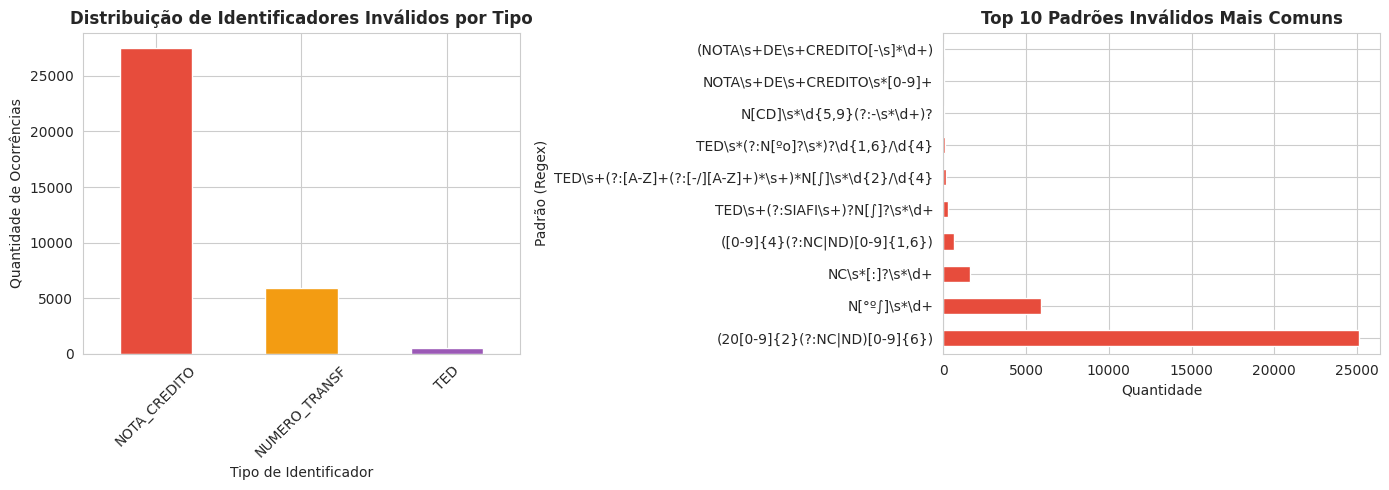

In [71]:
if len(df_padroes_invalidos) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: Distribuição de padrões inválidos por tipo
    df_padroes_invalidos['tipo'].value_counts().plot(
        kind='bar', ax=axes[0], color=['#e74c3c', '#f39c12', '#9b59b6']
    )
    axes[0].set_title('Distribuição de Identificadores Inválidos por Tipo', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Tipo de Identificador')
    axes[0].set_ylabel('Quantidade de Ocorrências')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Top 10 padrões inválidos mais comuns
    top_padroes = df_padroes_invalidos['regex'].value_counts().head(10)
    if len(top_padroes) > 0:
        top_padroes.plot(kind='barh', ax=axes[1], color='#e74c3c')
        axes[1].set_title('Top 10 Padrões Inválidos Mais Comuns', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Quantidade')
        axes[1].set_ylabel('Padrão (Regex)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Sem dados para visualizar padrões inválidos")

### Resumo Visual - Questão 1

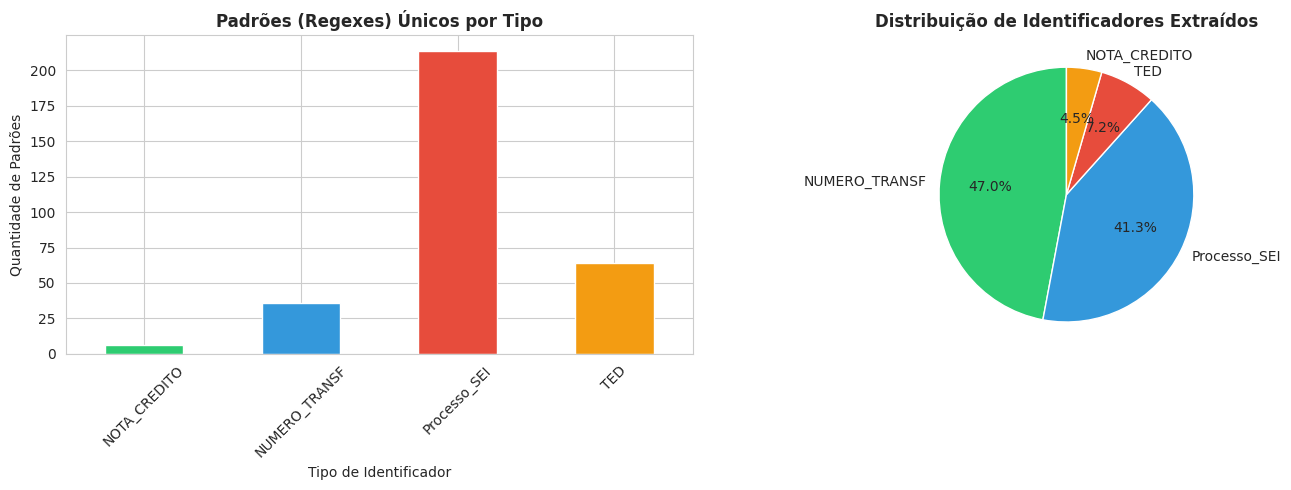

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Padrões por tipo
padroes_por_tipo.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
axes[0].set_title('Padrões (Regexes) Únicos por Tipo', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tipo de Identificador')
axes[0].set_ylabel('Quantidade de Padrões')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribuição de identificadores
contagem_tipos = df_identificadores['tipo'].value_counts()
contagem_tipos.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                     colors=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'], startangle=90)
axes[1].set_title('Distribuição de Identificadores Extraídos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

---
# QUESTÃO 2: Notas que Mencionam "TED"

### 2.1. Quantas notas de empenho tinham menção explícita ao termo "TED"?
### 2.2. Essa quantidade representa qual percentual do total de notas analisadas?

In [60]:
total_notas = len(df)
notas_menciona_ted = df['menciona_ted'].sum()
percentual_menciona_ted = (notas_menciona_ted / total_notas) * 100

print(f"2.1. Total de notas que mencionam 'TED': {notas_menciona_ted:,}")
print(f"2.2. Percentual do total: {percentual_menciona_ted:.2f}%")

2.1. Total de notas que mencionam 'TED': 48,257
2.2. Percentual do total: 15.10%


### 2.3. Em quantas dessas notas foi encontrado o número de transferência?
### 2.4. Esse número representa qual percentual do escopo da segunda etapa?

In [61]:
df_ted = df[df['menciona_ted'] == True]
ted_com_transf = df_ted['tem_numero_transf'].sum()
percentual_ted_com_transf = (ted_com_transf / notas_menciona_ted) * 100

print(f"2.3. Notas com TED + Número Transferência: {ted_com_transf:,}")
print(f"2.4. Percentual (do escopo TED): {percentual_ted_com_transf:.2f}%")

2.3. Notas com TED + Número Transferência: 22,226
2.4. Percentual (do escopo TED): 46.06%


### 2.5. Em quantas notas foi encontrado um número válido de nota de crédito?

In [62]:
ted_com_nc = df_ted['tem_nota_credito'].sum()
percentual_ted_com_nc = (ted_com_nc / notas_menciona_ted) * 100

print(f"2.5. Notas com TED + Nota de Crédito: {ted_com_nc:,}")
print(f"     Percentual: {percentual_ted_com_nc:.2f}%")

2.5. Notas com TED + Nota de Crédito: 4,429
     Percentual: 9.18%


### 2.6. Em quantas notas foi encontrado um número inválido ou incompleto de nota de crédito?

In [63]:
ted_sem_nc = len(df_ted) - ted_com_nc
percentual_ted_sem_nc = (ted_sem_nc / notas_menciona_ted) * 100

print(f"2.6. Notas com TED sem NC (possivelmente inválida/ausente): {ted_sem_nc:,}")
print(f"     Percentual: {percentual_ted_sem_nc:.2f}%")

2.6. Notas com TED sem NC (possivelmente inválida/ausente): 43,828
     Percentual: 90.82%


### 2.6.1. Em quantas notas que mencionam TED foi encontrada uma Nota de Crédito inválida/incompleta?

In [59]:
# Analisar Notas de Crédito inválidas em notas que mencionam TED
# NC válida deve seguir o padrão: YYYYNCNNNNNN (ex: 2025NC002149)
# Regex para validar: (\d{4}NC\d{6})

nc_invalidas_com_ted = []

# Processar apenas notas que mencionam TED
for nota in resultados:
    colunas = nota.get('colunas_analisadas', {})
    texto_completo = ' '.join([str(v) for v in colunas.values()])
    
    # Verificar se menciona TED
    if 'TED' not in texto_completo.upper():
        continue
    
    # Verificar identificadores de nota de crédito
    identificadores = nota.get('identificadores_encontrados', [])
    
    for id_info in identificadores:
        if id_info['tipo'] == 'NOTA_CREDITO':
            valor = id_info.get('valor_extraido', '')
            
            # Verificar se NÃO corresponde ao padrão válido
            if not re.match(r'^\d{4}NC\d{6}$', valor):
                nc_invalidas_com_ted.append({
                    'sequencial': nota['sequencial'],
                    'valor': valor,
                    'regex': id_info['regex_usado']
                })

df_nc_invalidas = pd.DataFrame(nc_invalidas_com_ted)

if len(df_nc_invalidas) > 0:
    notas_com_nc_invalida = df_nc_invalidas['sequencial'].nunique()
    notas_menciona_ted = df['menciona_ted'].sum()
    print(f"2.6.1. Notas que mencionam TED com NC inválida/incompleta: {notas_com_nc_invalida:,}")
    print(f"       Total de ocorrências de NC inválida: {len(df_nc_invalidas):,}")
    print(f"       Percentual (das que mencionam TED): {(notas_com_nc_invalida / notas_menciona_ted * 100):.2f}%")
    print(f"\nExemplos de NCs inválidas:")
    print(df_nc_invalidas[['valor']].head(10))
else:
    notas_com_nc_invalida = 0
    print("2.6.1. Nenhuma NC inválida encontrada em notas que mencionam TED")

2.6.1. Notas que mencionam TED com NC inválida/incompleta: 2,276
       Total de ocorrências de NC inválida: 2,599
       Percentual (das que mencionam TED): 4.72%

Exemplos de NCs inválidas:
                    valor
0  NOTA DE CREDITO 967171
1  NOTA DE CREDITO 967171
2  NOTA DE CREDITO 967171
3  NOTA DE CREDITO 967171
4  NOTA DE CREDITO 967171
5  NOTA DE CREDITO-967171
6  NOTA DE CREDITO-967171
7  NOTA DE CREDITO 967171
8  NOTA DE CREDITO 967171
9  NOTA DE CREDITO 967171


### 2.7. Quantas notas (no total da segunda etapa) possuíam algum identificador sistêmico válido (transferência ou NC)?

In [64]:
ted_com_sistemico = df_ted['tem_identificador_sistemico'].sum()
percentual_ted_com_sistemico = (ted_com_sistemico / notas_menciona_ted) * 100

print(f"2.7. Notas com TED + identificador sistêmico: {ted_com_sistemico:,}")
print(f"     Percentual: {percentual_ted_com_sistemico:.2f}%")

2.7. Notas com TED + identificador sistêmico: 22,318
     Percentual: 46.25%


In [78]:
# Análise detalhada das notas que mencionam TED (considerando validações)

# Filtrar apenas notas que mencionam TED
df_menciona_ted = df[df['menciona_ted'] == True]

# 1. Notas de crédito VÁLIDAS (no escopo TED)
ted_nc_validas = df_menciona_ted['tem_nota_credito_valida'].sum()

# 2. Notas de crédito INVÁLIDAS (no escopo TED)
# Notas que têm NC detectada MAS não é válida
ted_nc_invalidas = df_menciona_ted[
    (df_menciona_ted['tem_nota_credito'] == True) & 
    (df_menciona_ted['tem_nota_credito_valida'] == False)
].shape[0]

# 3. Notas com identificador sistêmico VÁLIDO (transferência OU NC)
ted_com_id_sistemico_valido = df_menciona_ted['tem_identificador_sistemico_valido'].sum()

# 4. Notas que mencionam TED e estão explicitamente "sem vínculo"
ted_sem_vinculo = df_menciona_ted['tem_sem_vinculo_ted'].sum()

# 5. Notas restantes sem explicação
# (mencionam TED, não têm ID sistêmico válido, e não têm marcação "sem vínculo")
ted_sem_explicacao = df_menciona_ted[
    (df_menciona_ted['tem_identificador_sistemico_valido'] == False) &
    (df_menciona_ted['tem_sem_vinculo_ted'] == False)
].shape[0]

# Exibir resultados
print("=== ANÁLISE DETALHADA: Notas que Mencionam TED (com validações) ===\n")
print(f"Total de notas que mencionam TED:                    {len(df_menciona_ted):,}")
print(f"                                   Percentual:       {(len(df_menciona_ted) / len(df) * 100):.2f}%")

print(f"\n--- 1. Notas de Crédito VÁLIDAS ---")
print(f"Notas com NC VÁLIDA (menciona TED):                  {ted_nc_validas:,}")
print(f"                                   Percentual (TED): {(ted_nc_validas / len(df_menciona_ted) * 100):.2f}%")

print(f"\n--- 2. Notas de Crédito INVÁLIDAS ---")
print(f"Notas com NC INVÁLIDA (menciona TED):                {ted_nc_invalidas:,}")
print(f"                                   Percentual (TED): {(ted_nc_invalidas / len(df_menciona_ted) * 100):.2f}%")

print(f"\n--- 3. Identificadores Sistêmicos VÁLIDOS ---")
print(f"Notas com ID sistêmico VÁLIDO (Transf. ou NC):       {ted_com_id_sistemico_valido:,}")
print(f"                                   Percentual (TED): {(ted_com_id_sistemico_valido / len(df_menciona_ted) * 100):.2f}%")

print(f"\n--- 4. Explicitamente 'Sem Vínculo com TED' ---")
print(f"Notas com marcação 'SEM VINCULO COM TED':            {ted_sem_vinculo:,}")
print(f"                                   Percentual (TED): {(ted_sem_vinculo / len(df_menciona_ted) * 100):.2f}%")

print(f"\n--- 5. Restantes Sem Explicação ---")
print(f"Notas SEM ID válido E SEM 'sem vínculo':             {ted_sem_explicacao:,}")
print(f"                                   Percentual (TED): {(ted_sem_explicacao / len(df_menciona_ted) * 100):.2f}%")

print(f"\n--- Verificação de Totalização ---")
print(f"Com ID válido:                                       {ted_com_id_sistemico_valido:,}")
print(f"Sem ID válido (sem vínculo + sem explicação):        {ted_sem_vinculo + ted_sem_explicacao:,}")
print(f"TOTAL (conferência):                                 {ted_com_id_sistemico_valido + ted_sem_vinculo + ted_sem_explicacao:,}")
print(f"Total que menciona TED:                              {len(df_menciona_ted):,}")

# Breakdown adicional: das que têm ID sistêmico válido
ted_apenas_transf_valida = df_menciona_ted[
    (df_menciona_ted['tem_numero_transf_valido'] == True) &
    (df_menciona_ted['tem_nota_credito_valida'] == False)
].shape[0]

ted_apenas_nc_valida = df_menciona_ted[
    (df_menciona_ted['tem_nota_credito_valida'] == True) &
    (df_menciona_ted['tem_numero_transf_valido'] == False)
].shape[0]

ted_ambos_validos = df_menciona_ted[
    (df_menciona_ted['tem_numero_transf_valido'] == True) &
    (df_menciona_ted['tem_nota_credito_valida'] == True)
].shape[0]

print(f"\n--- Breakdown dos ID Sistêmicos Válidos ---")
print(f"Apenas Núm. Transferência válido:                    {ted_apenas_transf_valida:,}")
print(f"Apenas NC válida:                                    {ted_apenas_nc_valida:,}")
print(f"Ambos válidos (Transf. + NC):                        {ted_ambos_validos:,}")
print(f"Total com ID sistêmico válido (conferência):         {ted_apenas_transf_valida + ted_apenas_nc_valida + ted_ambos_validos:,}")

=== ANÁLISE DETALHADA: Notas que Mencionam TED (com validações) ===

Total de notas que mencionam TED:                    48,257
                                   Percentual:       15.10%

--- 1. Notas de Crédito VÁLIDAS ---
Notas com NC VÁLIDA (menciona TED):                  2,153
                                   Percentual (TED): 4.46%

--- 2. Notas de Crédito INVÁLIDAS ---
Notas com NC INVÁLIDA (menciona TED):                2,276
                                   Percentual (TED): 4.72%

--- 3. Identificadores Sistêmicos VÁLIDOS ---
Notas com ID sistêmico VÁLIDO (Transf. ou NC):       12,718
                                   Percentual (TED): 26.35%

--- 4. Explicitamente 'Sem Vínculo com TED' ---
Notas com marcação 'SEM VINCULO COM TED':            22,399
                                   Percentual (TED): 46.42%

--- 5. Restantes Sem Explicação ---
Notas SEM ID válido E SEM 'sem vínculo':             13,183
                                   Percentual (TED): 27.32%

--- V

### 2.8. Análise Detalhada: Notas que Mencionam TED (com validações)

### Resumo Visual - Questão 2

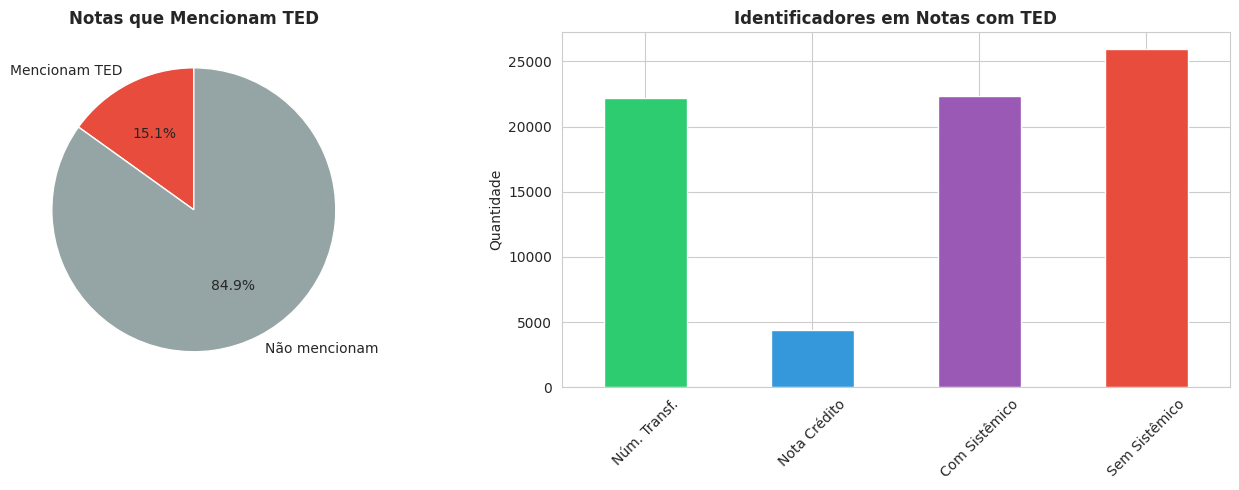

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Menção a TED
dados_mencao = pd.Series({
    'Mencionam TED': notas_menciona_ted,
    'Não mencionam': total_notas - notas_menciona_ted
})
dados_mencao.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                  colors=['#e74c3c', '#95a5a6'], startangle=90)
axes[0].set_title('Notas que Mencionam TED', fontsize=12, fontweight='bold')
axes[0].set_ylabel('')

# Gráfico 2: Breakdown identificadores em notas com TED
dados_breakdown = pd.Series({
    'Núm. Transf.': ted_com_transf,
    'Nota Crédito': ted_com_nc,
    'Com Sistêmico': ted_com_sistemico,
    'Sem Sistêmico': len(df_ted) - ted_com_sistemico
})
dados_breakdown.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
axes[1].set_title('Identificadores em Notas com TED', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Quantidade')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
# QUESTÃO 3: Identificadores Não Sistêmicos (Número do TED)

### 3.1. Quantas notas possuíam número de TED?

In [65]:
notas_com_ted = df['tem_ted'].sum()
percentual_com_ted = (notas_com_ted / total_notas) * 100

print(f"3.1. Total de notas com número de TED: {notas_com_ted:,}")
print(f"     Percentual do total: {percentual_com_ted:.2f}%")

3.1. Total de notas com número de TED: 29,992
     Percentual do total: 9.38%


In [39]:
notas_com_ted = (df['tem_ted'] & df['menciona_ted']).sum()
print(f"3.1. Total de notas com número de TED: {notas_com_ted:,}")

3.1. Total de notas com número de TED: 24,462


### 3.2. Quantas dessas notas dependiam exclusivamente do número de TED (não tinham transferência nem nota de crédito)?

In [66]:
notas_so_ted = df[
    (df['tem_ted'] == True) & 
    (df['tem_numero_transf'] == False) & 
    (df['tem_nota_credito'] == False)
].shape[0]

percentual_so_ted = (notas_so_ted / notas_com_ted) * 100

print(f"3.2. Notas dependentes EXCLUSIVAMENTE de TED: {notas_so_ted:,}")
print(f"     Percentual (do total com TED): {percentual_so_ted:.2f}%")

3.2. Notas dependentes EXCLUSIVAMENTE de TED: 4,831
     Percentual (do total com TED): 16.11%


### Resumo Visual - Questão 3

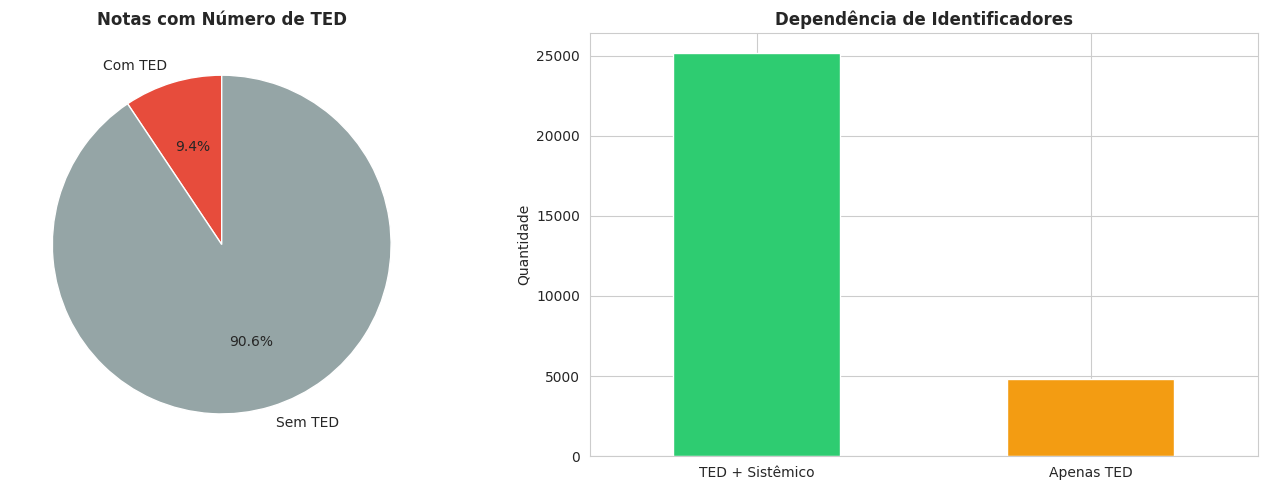

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Notas com número de TED
dados_ted = pd.Series({
    'Com TED': notas_com_ted,
    'Sem TED': total_notas - notas_com_ted
})
dados_ted.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
               colors=['#e74c3c', '#95a5a6'], startangle=90)
axes[0].set_title('Notas com Número de TED', fontsize=12, fontweight='bold')
axes[0].set_ylabel('')

# Gráfico 2: Dependência de TED
dados_dependencia = pd.Series({
    'TED + Sistêmico': notas_com_ted - notas_so_ted,
    'Apenas TED': notas_so_ted
})
dados_dependencia.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f39c12'])
axes[1].set_title('Dependência de Identificadores', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Quantidade')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

---
# QUESTÃO 4: Notas Sem Identificadores Sistêmicos

### 4.1. Quantas notas não possuíam número de transferência nem nota de crédito válida?

In [67]:
notas_sem_sistemico = (~df['tem_identificador_sistemico']).sum()
percentual_sem_sistemico = (notas_sem_sistemico / total_notas) * 100

print(f"4.1. Notas sem transferência E sem NC: {notas_sem_sistemico:,}")
print(f"     Percentual do total: {percentual_sem_sistemico:.2f}%")

4.1. Notas sem transferência E sem NC: 96,307
     Percentual do total: 30.13%


### 4.2. Dentre essas notas, quantas possuíam menção explícita indicando que não eram vinculadas a TEDs?

In [68]:
sem_sistemico_e_nao_ted = df[
    (~df['tem_identificador_sistemico']) & 
    (df['tem_sem_vinculo_ted'] == True)
].shape[0]

percentual_nao_ted = (sem_sistemico_e_nao_ted / notas_sem_sistemico) * 100

print(f"4.2. Dessas, com 'SEM VINCULO COM TED': {sem_sistemico_e_nao_ted:,}")
print(f"     Percentual (das sem sistêmico): {percentual_nao_ted:.2f}%")

4.2. Dessas, com 'SEM VINCULO COM TED': 20,668
     Percentual (das sem sistêmico): 21.46%


### 4.3. Quantas notas restaram que mencionavam TED, mas sem nenhum identificador válido ou estavam em formato inválido?

In [69]:
ted_sem_identificador = df[
    (df['menciona_ted'] == True) & 
    (~df['tem_identificador_sistemico']) & 
    (df['tem_ted'] == False)
].shape[0]

percentual_ted_sem_id = (ted_sem_identificador / notas_menciona_ted) * 100

print(f"4.3. Notas que mencionam TED mas sem nenhum ID válido: {ted_sem_identificador:,}")
print(f"     Percentual (das que mencionam TED): {percentual_ted_sem_id:.2f}%")

4.3. Notas que mencionam TED mas sem nenhum ID válido: 21,108
     Percentual (das que mencionam TED): 43.74%


In [35]:
ted_sem_identificador = df[
    (df['menciona_ted'] == True) & 
    (~df['tem_identificador_sistemico'])
].shape[0]



print(f"4.3. Notas que mencionam TED mas sem nenhum ID válido: {ted_sem_identificador:,}")


4.3. Notas que mencionam TED mas sem nenhum ID válido: 25,939


In [37]:
# Notas restantes sem explicação (sem transferência, NC válida ou “sem vínculo”)
notas_restantes_sem_explicacao = df[
    (~df['tem_identificador_sistemico']) & 
    (df['tem_sem_vinculo_ted'] == False) &
    (df['menciona_ted'] == True)

]
print(f"Notas restantes sem explicação (sem transferência, NC válida ou “sem vínculo”): {len(notas_restantes_sem_explicacao):,}")     
print(f"Porcentagem do total: {len(notas_restantes_sem_explicacao) / len(df) * 100:.2f}%")

Notas restantes sem explicação (sem transferência, NC válida ou “sem vínculo”): 5,271
Porcentagem do total: 1.65%


### Resumo Visual - Questão 4

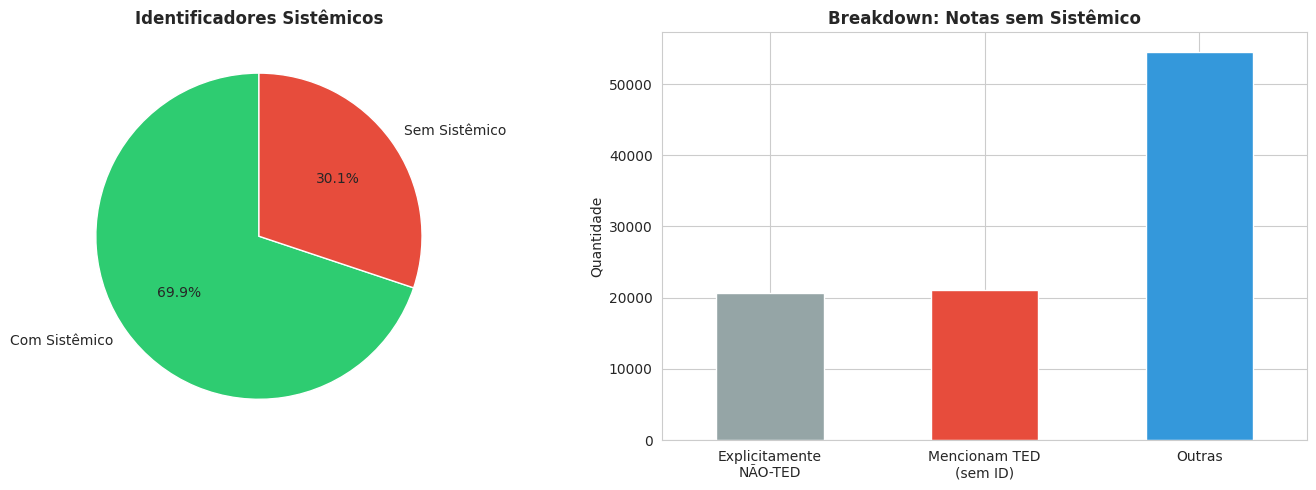

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Notas com/sem identificador sistêmico
dados_sistemico = pd.Series({
    'Com Sistêmico': total_notas - notas_sem_sistemico,
    'Sem Sistêmico': notas_sem_sistemico
})
dados_sistemico.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                     colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0].set_title('Identificadores Sistêmicos', fontsize=12, fontweight='bold')
axes[0].set_ylabel('')

# Gráfico 2: Breakdown das sem sistêmico
outras_sem_sistemico = notas_sem_sistemico - sem_sistemico_e_nao_ted - ted_sem_identificador
dados_breakdown = pd.Series({
    'Explicitamente\nNÃO-TED': sem_sistemico_e_nao_ted,
    'Mencionam TED\n(sem ID)': ted_sem_identificador,
    'Outras': outras_sem_sistemico
})
dados_breakdown.plot(kind='bar', ax=axes[1], color=['#95a5a6', '#e74c3c', '#3498db'])
axes[1].set_title('Breakdown: Notas sem Sistêmico', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Quantidade')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

---
# Resumo Consolidado - Todas as Questões

### Tabela Resumo Geral

In [70]:
# Criar DataFrame com todas as respostas
resumo = pd.DataFrame([
    {'Questão': '1.1', 'Descrição': 'Padrões válidos (Transf + NC)', 'Valor': total_padroes_validos, 'Percentual': ''},
    {'Questão': '1.2', 'Descrição': 'Padrões TED', 'Valor': padroes_ted, 'Percentual': ''},
    {'Questão': '1.3', 'Descrição': 'Notas com SEM VINCULO TED', 'Valor': notas_sem_vinculo_ted, 'Percentual': f'{(notas_sem_vinculo_ted/total_notas*100):.2f}%'},
    {'Questão': '1.4', 'Descrição': 'Padrões inválidos identificados', 'Valor': padroes_invalidos_unicos, 'Percentual': f'{(len(df_padroes_invalidos)/len(df_identificadores)*100):.2f}%'},
    {'Questão': '', 'Descrição': '', 'Valor': '', 'Percentual': ''},
    {'Questão': '2.1-2.2', 'Descrição': 'Notas que mencionam TED', 'Valor': notas_menciona_ted, 'Percentual': f'{percentual_menciona_ted:.2f}%'},
    {'Questão': '2.3-2.4', 'Descrição': 'Destas: com Núm. Transferência', 'Valor': ted_com_transf, 'Percentual': f'{percentual_ted_com_transf:.2f}%'},
    {'Questão': '2.5', 'Descrição': 'Destas: com Nota Crédito', 'Valor': ted_com_nc, 'Percentual': f'{percentual_ted_com_nc:.2f}%'},
    {'Questão': '2.6', 'Descrição': 'Destas: sem NC', 'Valor': ted_sem_nc, 'Percentual': f'{percentual_ted_sem_nc:.2f}%'},
    {'Questão': '2.6.1', 'Descrição': 'NC inválidas (das que mencionam TED)', 'Valor': notas_com_nc_invalida, 'Percentual': f'{(notas_com_nc_invalida/notas_menciona_ted*100):.2f}%'},
    {'Questão': '2.7', 'Descrição': 'Destas: com ID Sistêmico', 'Valor': ted_com_sistemico, 'Percentual': f'{percentual_ted_com_sistemico:.2f}%'},
    {'Questão': '', 'Descrição': '', 'Valor': '', 'Percentual': ''},
    {'Questão': '3.1', 'Descrição': 'Notas com número de TED', 'Valor': notas_com_ted, 'Percentual': f'{percentual_com_ted:.2f}%'},
    {'Questão': '3.2', 'Descrição': 'Destas: dependem APENAS de TED', 'Valor': notas_so_ted, 'Percentual': f'{percentual_so_ted:.2f}%'},
    {'Questão': '', 'Descrição': '', 'Valor': '', 'Percentual': ''},
    {'Questão': '4.1', 'Descrição': 'Notas sem ID Sistêmico', 'Valor': notas_sem_sistemico, 'Percentual': f'{percentual_sem_sistemico:.2f}%'},
    {'Questão': '4.2', 'Descrição': 'Destas: SEM VINCULO TED', 'Valor': sem_sistemico_e_nao_ted, 'Percentual': f'{percentual_nao_ted:.2f}%'},
    {'Questão': '4.3', 'Descrição': 'Mencionam TED sem ID válido', 'Valor': ted_sem_identificador, 'Percentual': f'{percentual_ted_sem_id:.2f}%'},
])

resumo

,Questão,Descrição,Valor,Percentual
0,1.1,Padrões válidos (Transf + NC),42,
1,1.2,Padrões TED,64,
2,1.3,Notas com SEM VINCULO TED,22399,7.01%
3,1.4,Padrões inválidos identificados,11,4.82%
4,,,,
5,2.1-2.2,Notas que mencionam TED,48257,15.10%
6,2.3-2.4,Destas: com Núm. Transferência,22226,46.06%
7,2.5,Destas: com Nota Crédito,4429,9.18%
8,2.6,Destas: sem NC,43828,90.82%
9,2.6.1,NC inválidas (das que mencionam TED),2276,4.72%


### Dashboard Visual Consolidado

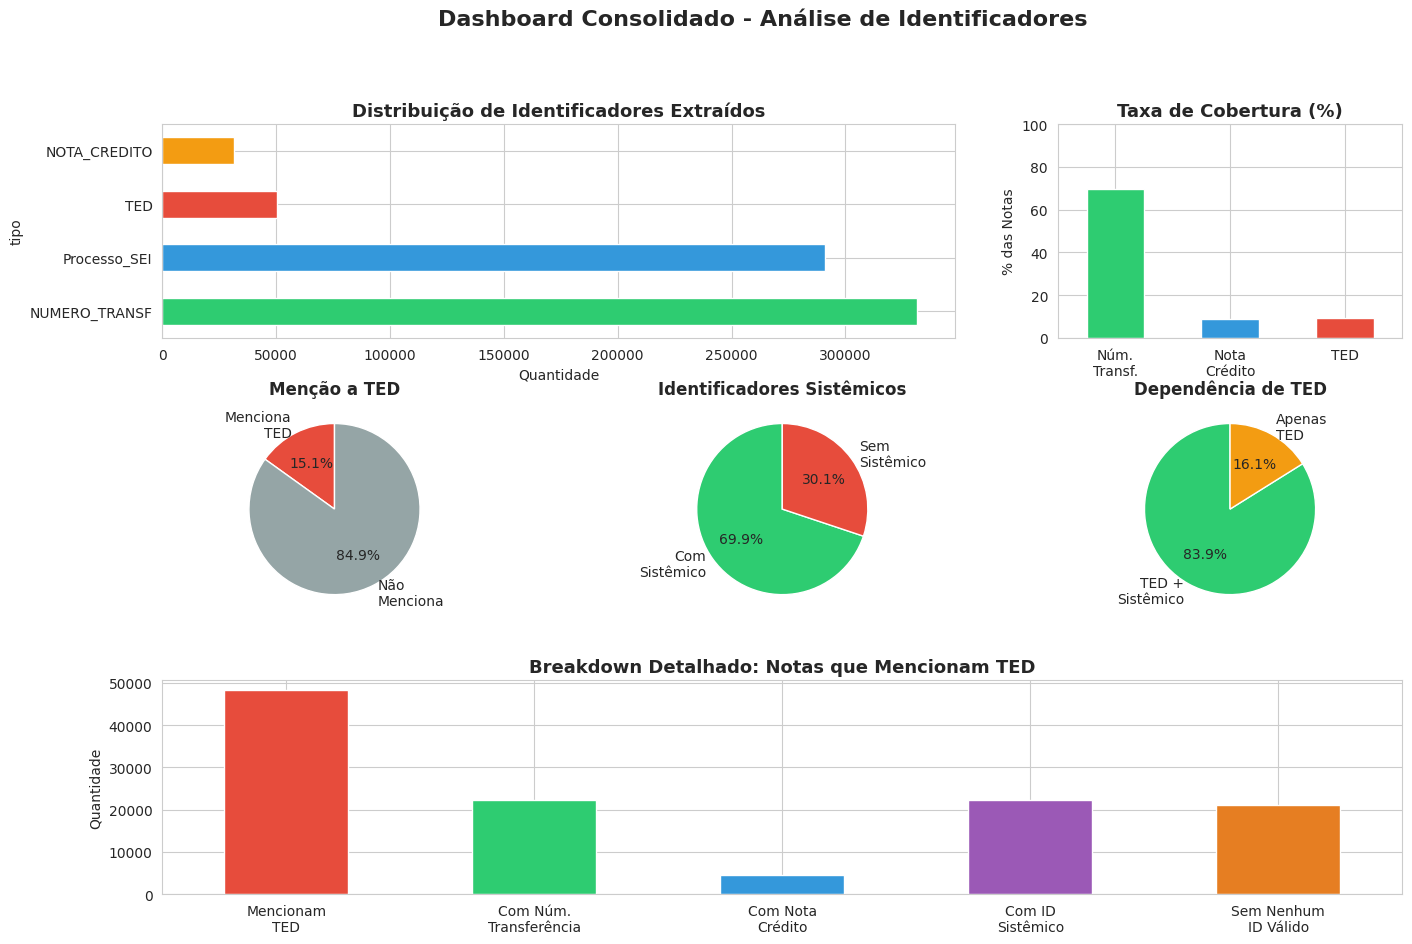

In [24]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribuição de identificadores
ax1 = fig.add_subplot(gs[0, :2])
contagem_tipos = df_identificadores['tipo'].value_counts()
contagem_tipos.plot(kind='barh', ax=ax1, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
ax1.set_title('Distribuição de Identificadores Extraídos', fontsize=13, fontweight='bold')
ax1.set_xlabel('Quantidade')

# 2. Taxa de cobertura
ax2 = fig.add_subplot(gs[0, 2])
taxa_cobertura = pd.Series({
    'Núm.\nTransf.': (df['tem_numero_transf'].sum() / total_notas * 100),
    'Nota\nCrédito': (df['tem_nota_credito'].sum() / total_notas * 100),
    'TED': (notas_com_ted / total_notas * 100)
})
taxa_cobertura.plot(kind='bar', ax=ax2, color=['#2ecc71', '#3498db', '#e74c3c'])
ax2.set_title('Taxa de Cobertura (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('% das Notas')
ax2.tick_params(axis='x', rotation=0)
ax2.set_ylim(0, 100)

# 3. Menção a TED
ax3 = fig.add_subplot(gs[1, 0])
dados_mencao = pd.Series({
    'Menciona\nTED': notas_menciona_ted,
    'Não\nMenciona': total_notas - notas_menciona_ted
})
dados_mencao.plot(kind='pie', ax=ax3, autopct='%1.1f%%', colors=['#e74c3c', '#95a5a6'], startangle=90)
ax3.set_title('Menção a TED', fontsize=12, fontweight='bold')
ax3.set_ylabel('')

# 4. Identificadores sistêmicos
ax4 = fig.add_subplot(gs[1, 1])
dados_sist = pd.Series({
    'Com\nSistêmico': total_notas - notas_sem_sistemico,
    'Sem\nSistêmico': notas_sem_sistemico
})
dados_sist.plot(kind='pie', ax=ax4, autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
ax4.set_title('Identificadores Sistêmicos', fontsize=12, fontweight='bold')
ax4.set_ylabel('')

# 5. Dependência de TED
ax5 = fig.add_subplot(gs[1, 2])
dados_dep = pd.Series({
    'TED +\nSistêmico': notas_com_ted - notas_so_ted,
    'Apenas\nTED': notas_so_ted
})
dados_dep.plot(kind='pie', ax=ax5, autopct='%1.1f%%', colors=['#2ecc71', '#f39c12'], startangle=90)
ax5.set_title('Dependência de TED', fontsize=12, fontweight='bold')
ax5.set_ylabel('')

# 6. Breakdown TED detalhado
ax6 = fig.add_subplot(gs[2, :])
dados_detail = pd.Series({
    'Mencionam\nTED': notas_menciona_ted,
    'Com Núm.\nTransferência': ted_com_transf,
    'Com Nota\nCrédito': ted_com_nc,
    'Com ID\nSistêmico': ted_com_sistemico,
    'Sem Nenhum\nID Válido': ted_sem_identificador
})
dados_detail.plot(kind='bar', ax=ax6, color=['#e74c3c', '#2ecc71', '#3498db', '#9b59b6', '#e67e22'])
ax6.set_title('Breakdown Detalhado: Notas que Mencionam TED', fontsize=13, fontweight='bold')
ax6.set_ylabel('Quantidade')
ax6.tick_params(axis='x', rotation=0)

plt.suptitle('Dashboard Consolidado - Análise de Identificadores', fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [2]:

notas_com_identificador = df[
    (df['tem_numero_transf'] == True) | (df['tem_numero_nota_credito'] == True) | (df['tem_numero_ted'] == True)
]
print(f"Notas com ao menos um identificador válido: {len(notas_com_identificador):,}")     

NameError: name 'df' is not defined

---
# Exportação de Resultados

### Exportar DataFrames para CSV

In [ ]:
# Exportar DataFrame principal
df.to_csv('df_notas_analise.csv', index=False, encoding='utf-8-sig')
print(f"✓ DataFrame de notas exportado: df_notas_analise.csv ({len(df):,} linhas)")

# Exportar DataFrame de identificadores
df_identificadores.to_csv('df_identificadores_analise.csv', index=False, encoding='utf-8-sig')
print(f"✓ DataFrame de identificadores exportado: df_identificadores_analise.csv ({len(df_identificadores):,} linhas)")

# Exportar resumo
resumo.to_csv('resumo_questoes.csv', index=False, encoding='utf-8-sig')
print(f"✓ Resumo de questões exportado: resumo_questoes.csv")

print("\n✅ ANÁLISE CONCLUÍDA COM SUCESSO!")